In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
import json
from os.path import expanduser


In [2]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
precursor_definition_method = 'pasef'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)

In [3]:
# select a precursor cuboid id to visualise
# FEATURES_DIR = "{}/features-{}".format(EXPERIMENT_DIR, precursor_definition_method)
# FEATURES_DEDUP_FILE = '{}/exp-{}-run-{}-features-{}-dedup.pkl'.format(FEATURES_DIR, experiment_name, run_name, precursor_definition_method)
# d = pd.read_pickle(FEATURES_DEDUP_FILE)
# features_df = d['features_df']
# precursor_cuboid_id = features_df.sample(n=1).iloc[0].precursor_cuboid_id
# precursor_cuboid_id

# some good precursors for analysis
# precursor_cuboid_id = 23911
# precursor_cuboid_id = 18601
precursor_cuboid_id = 35173

In [15]:
VIS_FILE = '{}/feature-detection-visualisation-{}.pkl'.format(expanduser("~"), precursor_cuboid_id)

In [16]:
# load the visualisation file for this precursor cuboid
vis_d = pd.read_pickle(VIS_FILE)
vis_d.keys()

dict_keys(['precursor_cuboid_d', 'wide_ms1_points_df', 'peaks_after_intensity_descent', 'deconvolution_features_df', 'features_df'])

In [17]:
features_df = vis_d['features_df']
features_df

,mz_apex_without_saturation_correction,mz_apex_with_saturation_correction,mz_lower,mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,...,charge,monoisotopic_mass,feature_intensity,envelope,isotope_count,deconvolution_score,precursor_cuboid_id,fragment_ions_l,fmdw_before_after_d,feature_id
0,964.493476,964.491604,964.462757,964.524195,239.0,208,240,2064.846238,2060.083891,2071.193947,...,2,1926.968656,21181,"[[964.4934759909365, 47085.0], [964.9899454895...",4,455.857685,35173,"[{""singly_protonated_mass"": 288.2105, ""neutral...",{'before_fmdw': [{'singly_protonated_mass': 28...,3517301
1,966.494916,966.496252,966.464133,966.525698,203.0,165,240,2064.316138,2061.142138,2068.018871,...,2,1930.977950,329450,"[[966.4949157249653, 664422.0], [966.996734652...",4,2658.885863,35173,"[{""singly_protonated_mass"": 288.2105, ""neutral...",{'before_fmdw': [{'singly_protonated_mass': 28...,3517302
2,967.038408,967.028029,967.007609,967.069208,210.0,165,240,2074.370156,2071.723415,2074.370156,...,2,1932.041506,7407,"[[967.0384084096778, 22907.0], [967.5393065835...",4,458.189337,35173,"[{""singly_protonated_mass"": 288.2105, ""neutral...",{'before_fmdw': [{'singly_protonated_mass': 28...,3517303
3,967.950466,967.954229,967.919637,967.981295,201.0,165,222,2066.433093,2062.728918,2070.665493,...,2,1933.893906,33170,"[[967.9504661005637, 42369.0], [968.4415545935...",4,375.174363,35173,"[{""singly_protonated_mass"": 288.2105, ""neutral...",{'before_fmdw': [{'singly_protonated_mass': 28...,3517304


In [18]:
selected_feature = 2
selected_feature_id = features_df.iloc[selected_feature-1].feature_id
selected_feature_id

3517302

In [8]:
fragment_ions_before_df = pd.DataFrame(features_df.iloc[selected_feature-1].fmdw_before_after_d['before_fmdw'])
fragment_ions_before_df['normalised_intensity'] = fragment_ions_before_df.intensity / fragment_ions_before_df.intensity.max()

fragment_ions_after_df = pd.DataFrame(features_df.iloc[selected_feature-1].fmdw_before_after_d['after_fmdw'])
fragment_ions_after_df['normalised_intensity'] = fragment_ions_after_df.intensity / fragment_ions_after_df.intensity.max()


In [9]:
reduced_by = (len(fragment_ions_before_df) - len(fragment_ions_after_df)) / len(fragment_ions_before_df) * 100
print('{} ions before, {} ions after, {}% reduction'.format(len(fragment_ions_before_df), len(fragment_ions_after_df), round(reduced_by)))

205 ions before, 166 ions after, 19% reduction


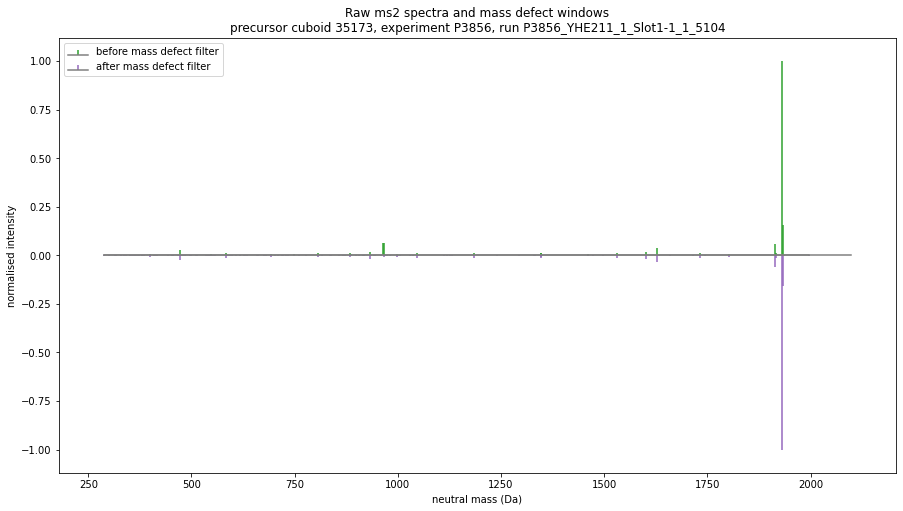

In [10]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# plot the raw data
markerline, stemlines, baseline = ax.stem(fragment_ions_before_df.neutral_mass, fragment_ions_before_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='before mass defect filter')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', 'tab:gray')

# plot the filtered data
markerline, stemlines, baseline = ax.stem(fragment_ions_after_df.neutral_mass, -fragment_ions_after_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='after mass defect filter')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.xlabel('neutral mass (Da)')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra and mass defect windows\nprecursor cuboid {}, experiment {}, run {}'.format(precursor_cuboid_id, experiment_name, run_name))
plt.show()